### Below is a prototype animation for RandomWaypoint nodes mobility

N_trajectories = 5
[700.51999999999998, 700.42999999999995, 700.73000000000002]
(5, 900, 3)
good ending!!


<IPython.core.display.Javascript object>


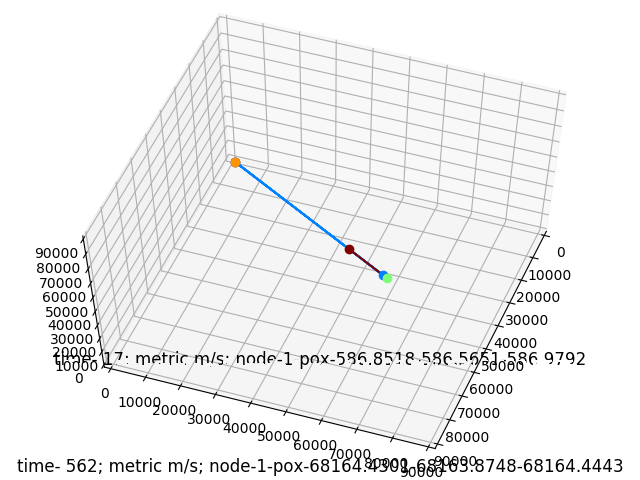

Good Ending!!


In [1]:
%matplotlib notebook
import re
import sys
import inspect
from math import sqrt
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
#=========================== 
# debug macro
def debug(value):
        calling_frame_record = inspect.stack()[1]
        frame = inspect.getframeinfo(calling_frame_record[0])
        m = re.search( "dd\((.+)\)", frame.code_context[0])
        if m:
            print("'{0}' = '{1}'" .format(m.group(1), value))
# init some trace info
axlimits = int(90000)
maxspeed = int(axlimits / 50)
T_max = 900
teg_num = 8
Frames_n = T_max
#====
# read the trace file
trace_file = open("../../box/current_trace/current_trace.tcl", "r")
lines = trace_file.readlines();
trace_file.close()
#====
# define TimeState
class TimeState :
    def __init__(self, time, node, dest, velocity) :
        self.time_ = float(time)
        self.node_ = int(node)
        self.dest_ = dest
        vv = float(velocity)
        while vv > float(maxspeed) :
            vv = round(vv / 2, 5)
        self.velocity_ = vv
    def __str__(self):
        return "<TimeState: time_ = %f, node = %d, dest = %s, velocity = %f>" % (self.time_, self.node_, self.dest_, self.velocity_)
# end-define
#====
# define Position
class Position :
    def __init__(self, x, y, z) :
        self.x_ = float(x)
        self.y_ = float(y)
        self.z_ = float(z)
    def __str__(self) :
        return "<Position: x_ = %f, y_ = %f, z = %f>" % (self.x_, self.y_, self.z_)
    def tolist(self) :
        return [float(self.x_), float(self.y_), float(self.z_)]
def CreatePosition() :
    tmp = Position(-1, -1, -1)
    return tmp
def CreateNodeState() :
    empty_node_state = {'origin_pos' : CreatePosition(), 'time_changes' : []}
    return empty_node_state
# end-define
nodes_info = []
# parse every line
for line in lines :
    #print(line)
    match_sharp_then_skip = re.findall(r'\#',line)
    if match_sharp_then_skip :
        continue
    #node_
    match_object = re.match(r'\$node_\((\d+\.*\d*)\) set ([XYZ])_ (\d+\.*\d*)', line)
    if match_object :
        node_number = int(match_object.group(1))
        if match_object.group(2) == 'X' :
            nodes_info.append(CreateNodeState())
            nodes_info[node_number]['origin_pos'].x_ = match_object.group(3)
        elif match_object.group(2) == 'Y' :
            nodes_info[node_number]['origin_pos'].y_ = match_object.group(3)
        elif match_object.group(2) == 'Z' :
            nodes_info[node_number]['origin_pos'].z_ = match_object.group(3)
    else :
        #ns_
        match_ob = re.match(r'\$ns_ at (\d+\.*\d*) \"\$node_\((\d+\.*\d*)\) setdest (\d+\.*\d*) (\d+\.*\d*) (\d+\.*\d*) (\d+\.*\d*)\"', line)
        if match_ob == None:
            print("can't match any! null!")
            sys.exit()
        node_number = int(match_ob.group(2))
        # tmp is reference semantic, so this work
        tmp = nodes_info[node_number]['time_changes']
        
        tmp_ts = TimeState(match_ob.group(1),
                           match_ob.group(2),
                           Position(match_ob.group(3), match_ob.group(4), match_ob.group(5)),
                           match_ob.group(6))
        tmp.append(tmp_ts)
# end-parse
"""
#====
# define PrintNodeInfo
def PrintNodeInfo(node_info) :
    for keys,values in node_info.items() :
        print(keys)
        if isinstance(values, list) :
            for v in values :
                print(v)
        elif isinstance(values, Position) :
            print(values)
# end-define

# print nodes_info
for node_info in nodes_info :
    PrintNodeInfo(node_info)
# end-print
"""

#============================================ dividing line ===============================================
#====
# calculate draw data : chech this link : 
# https://jakevdp.github.io/blog/2013/02/16/animating-the-lorentz-system-in-3d/
N_trajectories = len(nodes_info)
print("N_trajectories = %d" % int(N_trajectories))
# this is a array for original position, should be (N_trajectories, 3) shape
pos_0_l = []
for i in range(0, N_trajectories)  :
    pos_0_l.append(nodes_info[i]['origin_pos'].tolist())
pos_0 = np.array(pos_0_l)
# this should be a vector, describe the simulate time, like this np.linspace(0, 4, 1000)
time_vec = np.linspace(0, 1, T_max)

# define PTVGenarator(position time variable genarator)
# ==============================
# =======================
# == Important! change the method pos_t algebra-ed with, if you want.
# ====================
class PTVGenarator :
    def __init__(self, orip, ts) :
        self.ts_ = ts
        self.curp_ = orip.tolist()
        self.curt_ = int(0)
        # next ts index
        self.tsi_ = 0
        self.vx_ = 0
        self.vy_ = 0
        self.vz_ = 0
        #self.getpos(0)
    def get_pos_detail(self, t) :
        if (self.tsi_ == len(self.ts_)) or (self.curt_ < int(self.ts_[self.tsi_].time_)) :
            # do nothing
            nomeaning = "if tsi_ == len(self.ts_), we thought it would go as before"
        else :
            # modify
            ts_var = self.ts_[self.tsi_]
            dest_list = ts_var.dest_.tolist()
            speed = round(ts_var.velocity_, 4)
            dx = round(dest_list[0] - self.curp_[0], 2)
            dy = round(dest_list[1] - self.curp_[1], 2)
            dz = round(dest_list[2] - self.curp_[2], 2)
            deslen = sqrt(dx * dx + dy * dy + dz * dz)
            self.vx_ = round(speed * (float(dx) / deslen), 4)
            self.vy_ = round(speed * (float(dy) / deslen), 4)
            self.vz_ = round(speed * (float(dz) / deslen), 4)
            self.tsi_ += 1
        # move
        self.curt_ = t
        self.curp_ = [round(self.vx_ + self.curp_[0], 4),
                      round(self.vy_ + self.curp_[1], 4),
                      round(self.vz_ + self.curp_[2], 4)]
        return self.curp_
    # t would be 0,1.....599
    def get_pos(self, t) :
        if t < T_max :
            return self.get_pos_detail(t)
        else :
            print("t is bigger than T_max")
# end-define PTVGenarator

# this is a expression for position on time_vec, should be the (N_trajectories, time_vec.max, 3) shape
pt = []
for i in range(0, N_trajectories, 1) :
    pt.append([])
    ptvg_i = PTVGenarator(nodes_info[i]['origin_pos'], nodes_info[i]['time_changes'])
    # note, because time in nodes_info is double and double is not a friendly data type for visualization,
    # so we would do this with the int data type which would cause some precise loose
    for t in range(0, T_max, 1) :
        pt[i].append([])
        if t != 0 :
            # calculate time-changing pos
            pt[i][t] = ptvg_i.get_pos(t)
        else :
            # origin pos
            tx = pos_0[i][0]
            ty = pos_0[i][1]
            tz = pos_0[i][2]
            pt[i][t] = [round(tx, 2), round(ty, 2), round(tz, 2)]
            if i == 3 :
                print(pt[3][0])
pos_t = np.array(pt)
print(np.shape(pos_t))
print("good ending!!")
# end-calculate
#====
# output the position of nodes. 'pt'.
# 

with open('../../box/current_trace/teg.txt', 'w') as teg_f:
    for i in range(0, N_trajectories, 1) :
        for t in range(0, T_max, int(T_max / teg_num)) :
            teg_f.write('node {0} time {1} pos {2} {3} {4}\n'.
                        format(i, t, int(pt[i][t][0]), int(pt[i][t][1]), int(pt[i][t][2])))
#====
# make graph
# Set up figure & 3D axis for animation
fig = plt.figure()
#Add an axes at position rect [left, bottom, width, height]
#where all quantities are in fractions of figure width and height. 
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('on')
# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))
# set up lines and points
lines = sum([ax.plot([], [], [], '-', c=c)
             for c in colors], [])
pts = sum([ax.plot([], [], [], 'o', c=c)
           for c in colors], [])
# prepare the axes limits
ax.set_xlim((0, axlimits))
ax.set_ylim((0, axlimits))
ax.set_zlim((0, axlimits))
# set point-of-view: specified by (altitude degrees, azimuth degrees)
#‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
ax.view_init(60, 20)
# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts
# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    #i = (2 * i) % pos_t.shape[1]

    for line, pt, pos_ti in zip(lines, pts, pos_t):
        #.T means transpose of an array
        x, y, z = pos_ti[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    #ax.view_init(60, 0.3 * i)
    ax.view_init(60, 20)
    ax.set_title('time- {0}; metric m/s; node-{1}-pox-{2}-{3}-{4}'.
             format(i, 1, pos_t[1][i][0], pos_t[1][i][1], pos_t[1][i][2]))
    fig.canvas.draw()
    return lines + pts
# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Frames_n, interval=30, blit=True)
# Save as mp4. This requires mplayer or ffmpeg to be installed
## anim.save('lorentz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])
plt.show()
# end-make
print("Good Ending!!")